Illinois is famous for being one of the very few states in the country with negative population growth.  The objective of your final project is to:

1) Identify the key reasons for the declining population by extracting meaningful insights from unstructured text
2) Provide actionable recommendations on what can be done to reverse this trend
You have a collection of a couple of months’ worth of news articles in RCC located at: /project/msca/kadochnikov/news/news_chicago_il.pkl

 

The news articles are related to either Chicago and / or Illinois.

To complete your assignment, I suggest considering the following steps:

- Clean-up the noise (eliminate articles irrelevant to the analysis)
- Detect major topics
- Identify top reasons for population decline (negative sentiment)
    * Suggest corrective actions
- Demonstrate how the city / state can attract new businesses (positive sentiment)
- Leverage appropriate NLP techniques to identify organizations and people and apply targeted sentiment
    * Why businesses should stay in IL or move into IL?
        ** Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)
    * Why residents should stay in IL or move into IL?
        ** Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)

Additional guidance:

- Default sentiment will likely be wrong from any software package and will require significant tweaking
    * Either keyword / dictionary approach or
    * Labeling and classification
- You are encouraged to explore a combination several techniques to identify key topics:
    * Topic modeling (i.e. LSA, LDA and TF-IDF)
    * Classification (hand-label several topics on a sample and then train classifier)
    * Clustering (cluster topics around pre-selected keywords or word vectors)
- Please limit your work to 7 PowerPoint slides. On your slides you will want to provide:
    * Executive Summary
    * Methodology and source data overview
    * Actionable recommendations
- Please submit your actual program codes (i.e. Python Notebook) along with your PowerPoint – as a separate attachment
- Your presentation should be targeted toward business audience and must not contain any code snippets
- You are welcome to use any software packages of your choice to complete the assignment

In [1]:
import warnings

warnings.simplefilter('ignore')

import time
import math
import re
from textblob import TextBlob
import pandas as pd

import nltk as nltk
from nltk.stem.wordnet import WordNetLemmatizer

import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
import pyLDAvis.gensim
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [74]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

# Cleaning

In [2]:
df = pd.read_pickle("news_chicago_il.pkl")

In [3]:
df.head(5)

,crawled_date,language,text,title
0,2020-05-11,english,\nGov. Jay “Fatso” Pritzker called on all Illi...,All In Illinois
1,2020-05-11,english,"May 10, 2020 -The Illinois Department of Publi...",The Illinois Department of Public Health Annou...
2,2020-05-11,english,"Gloria Lawrence said: May 10, 2020 at 1:31 AM\...","Foto Friday: Alton, Illinois"
3,2020-05-11,english,NBA to follow German soccer league model with ...,Chris Broussard on Michael Jordan returning to...
4,2020-05-11,english,"Search Minggu, 10 Mei 2020 Pork chops vs. peop...",Pork chops vs. people: Can Americans’ appetite...


In [4]:
df.shape

(177325, 4)

Checking to make sure all articles are in English.

In [5]:
df.language.unique()

array(['english'], dtype=object)

Dropping columns not needed.

In [6]:
df = df.drop(['crawled_date','language'], axis=1)

I am making the assumption that articles with the same title have the same content. I will drop duplicates in main dataframe.

In [7]:
df = df.drop_duplicates(subset='title').reset_index(drop=True)
len(df)

138258

In [8]:
#df contains all duplicate titles

dup_df = pd.read_pickle("news_chicago_il.pkl")
dup_df['duplicate'] = dup_df.duplicated(subset='title', keep='first').reset_index(drop=True)
dup_df = dup_df[dup_df['duplicate'] == True]
len(dup_df)

39067

I want to include the title in case there is important info.

In [9]:
df['comb'] = df['title'] + ' ' + df['text']

In [10]:
words=[]
def stopwords(text):
    words=[w for w in text if w not in stopwords.words('english')]
    return words

In [11]:
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop = stopwords.words('english')

In [12]:
#remove stop words

df['comb'] = df['comb'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [13]:
clean=pd.DataFrame(df['comb'])

In [14]:
#lowercase

clean = pd.DataFrame(clean['comb'].apply(str.lower))

In [15]:
#remove special chars

clean['text_clean'] = clean['comb'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

In [16]:
#only need to keep clean text
clean=pd.DataFrame(clean['text_clean'])
clean.head()

,text_clean
0,all in illinois gov. jay fatso pritzker called...
1,the illinois department public health announce...
2,"foto friday: alton, illinois gloria lawrence s..."
3,chris broussard michael jordan returning chica...
4,pork chops vs. people: can americans appetite ...


Only keep articles related to population movement in IL/Chicago.

In [17]:
#stemmers

porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

In [18]:
#locations '(USA-IL-Chicago)','Illinois','Chicago'

key_words=['population','migration','exodus','moving','leaving']
in_stems=[porter.stem(c) for c in key_words]
new_stems=[]

for a in range(0, len(clean)):
    words=clean.iloc[a].text_clean
    stems=[porter.stem(t) for t in words.split()]
    if any(s in stems for s in in_stems):
        new_stems.append(a)
    else:
        continue

In [19]:
clean=clean.iloc[new_stems]
clean=clean.reset_index(drop=True)
len(clean)

26335

I will remove words that I don't feel explain people leaving IL.

In [20]:
#remove off-topic sports, animals, and Trump

words_list = ['bears','cubs','bulls','blackhawks','football','baseball','basketball','hockey','sox','Trump','deer','coyote','covid19','COVID',"COVID-19",'coronavirus']
p_stems = [porter.stem(x) for x in words_list]
l_stems = [lancaster.stem(x) for x in words_list]

print(p_stems)
print(l_stems)

['bear', 'cub', 'bull', 'blackhawk', 'footbal', 'basebal', 'basketbal', 'hockey', 'sox', 'trump', 'deer', 'coyot', 'covid19', 'covid', 'covid-19', 'coronaviru']
['bear', 'cub', 'bul', 'blackhawk', 'footbal', 'basebal', 'basketbal', 'hockey', 'sox', 'trump', 'deer', 'coyot', 'covid19', 'covid', 'covid-19', 'coronavir']


In [21]:
porter_stems=[]
for a in range(0, len(clean)):
    words=clean.iloc[a].text_clean
    stems=[porter.stem(t) for t in words.split()]
    if any(s in stems for s in p_stems):
        porter_stems.append(stems)
    else:
        porter_stems.append(None)

In [22]:
p_articles=[i for i in porter_stems if i is not None]
len(p_articles)

10992

In [23]:
clean['contain_stem']=pd.Series(porter_stems)
clean=clean[clean['contain_stem'].isnull()]
clean=clean.reset_index(drop=True)
len(clean)

15343

In [24]:
clean_df = clean
clean_df.head()

,text_clean,contain_stem
0,7 chicago officers injured altercation storage...,None
1,"real reason nigerian vblogger, ar, tolani baj ...",None
2,families frustrated chicagoarea cemeteries clo...,None
3,illinois tool works inc. nyse:itw ceo buys 998...,None
4,tradition asset management llc decreases stock...,None


# TF-IDF

https://stevenloria.com/tf-idf/

- tf(word, blob) computes "term frequency" which is the number of times a word appears in a document blob, normalized by dividing by the total number of words in blob. We use TextBlob for breaking up the text into words and getting the word counts.
- n_containing(word, bloblist) returns the number of documents containing word. A generator expression is passed to the sum() function.
- idf(word, bloblist) computes "inverse document frequency" which measures how common a word is among all documents in bloblist. The more common a word is, the lower its idf. We take the ratio of the total number of documents to the number of documents containing word, then take the log of that. Add 1 to the divisor to prevent division by zero.
- tfidf(word, blob, bloblist) computes the TF-IDF score. It's the product of tf and idf.

In [25]:
bloblist = []
del bloblist[:]

for i  in range(0,len(clean)):
    bloblist.append(TextBlob(clean['text_clean'].iloc[i]))
    
len(bloblist)

15343

In [26]:
def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [27]:
#top 5

for i, blob in enumerate(bloblist):
    if i == 5:
        break
    print("Top words in news article {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:10]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in news article 1
	Word: altercation, TF-IDF: 0.2734
	Word: officers, TF-IDF: 0.20763
	Word: storage, TF-IDF: 0.17529
	Word: injured, TF-IDF: 0.17139
	Word: male, TF-IDF: 0.09559
	Word: 8:16, TF-IDF: 0.09231
	Word: injuries, TF-IDF: 0.08797
	Word: sfgate, TF-IDF: 0.07939
	Word: authorities, TF-IDF: 0.07871
	Word: stabilized, TF-IDF: 0.07703
Top words in news article 2
	Word: tolani, TF-IDF: 0.57696
	Word: baj, TF-IDF: 0.46157
	Word: nigerian, TF-IDF: 0.40387
	Word: nigeria, TF-IDF: 0.39694
	Word: vblogger, TF-IDF: 0.37676
	Word: ar, TF-IDF: 0.35146
	Word: lagos, TF-IDF: 0.32829
	Word: real, TF-IDF: 0.13276
	Word: reason, TF-IDF: 0.12651
	Word: entrepreneurer, TF-IDF: 0.12135
Top words in news article 3
	Word: mothers, TF-IDF: 0.13321
	Word: gates, TF-IDF: 0.11302
	Word: cemeteries, TF-IDF: 0.10206
	Word: cemetery, TF-IDF: 0.06834
	Word: families, TF-IDF: 0.06452
	Word: harris, TF-IDF: 0.05731
	Word: stood, TF-IDF: 0.05213
	Word: console, TF-IDF: 0.05155
	Word: smith, TF-IDF: 

# LDA

In [28]:
df2list = clean['text_clean'].tolist()
df2list[:1]

['7 chicago officers injured altercation storage center  sfgate 7 chicago officers injured altercation storage center published 8:16 pdt, sunday, may 10, 2020 chicago ap  seven chicago police officers injured altercation saturday storage center citys near south side, authorities said. officers called storage facility around 11 a.m. reports male causing disturbance lobby. he allegedly refused leave property, prompting altercation officers. one officer hospitalized injuries shoulder knee stabilized. six officers treated scene minor injuries. police said male wasnt injured taken custody. authorities said charges pending. most popular']

In [29]:
doc_complete = []
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in doc_complete]

In [30]:
news_clean = [clean(doc).split() for doc in df2list]

In [31]:
len(news_clean)

15343

In [32]:
print(*news_clean[:1], sep='\n\n')

['7', 'chicago', 'officer', 'injured', 'altercation', 'storage', 'center', 'sfgate', '7', 'chicago', 'officer', 'injured', 'altercation', 'storage', 'center', 'published', '816', 'pdt', 'sunday', 'may', '10', '2020', 'chicago', 'ap', 'seven', 'chicago', 'police', 'officer', 'injured', 'altercation', 'saturday', 'storage', 'center', 'city', 'near', 'south', 'side', 'authority', 'said', 'officer', 'called', 'storage', 'facility', 'around', '11', 'am', 'report', 'male', 'causing', 'disturbance', 'lobby', 'allegedly', 'refused', 'leave', 'property', 'prompting', 'altercation', 'officer', 'one', 'officer', 'hospitalized', 'injury', 'shoulder', 'knee', 'stabilized', 'six', 'officer', 'treated', 'scene', 'minor', 'injury', 'police', 'said', 'male', 'wasnt', 'injured', 'taken', 'custody', 'authority', 'said', 'charge', 'pending', 'popular']


In [33]:
dictionary = corpora.Dictionary(news_clean)

#convert 2 corpus

doc_term_matrix = [dictionary.doc2bow(doc) for doc in news_clean]

In [34]:
#3 topic model
numtopics = 3

%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=numtopics, id2word = dictionary, passes=50)

Wall time: 13min 6s


In [35]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=3), sep='\n')

(0, '0.009*"illinois" + 0.008*"state" + 0.006*"chicago"')
(1, '0.017*"chicago" + 0.007*"said" + 0.005*"one"')
(2, '0.034*"share" + 0.023*"company" + 0.022*"stock"')


In [36]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=5), sep='\n\n')

(0, '0.009*"illinois" + 0.008*"state" + 0.006*"chicago" + 0.005*"said" + 0.004*"year"')

(1, '0.017*"chicago" + 0.007*"said" + 0.005*"one" + 0.004*"police" + 0.004*"time"')

(2, '0.034*"share" + 0.023*"company" + 0.022*"stock" + 0.020*"quarter" + 0.019*"rating"')


In [37]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=10), sep='\n\n')

(0, '0.009*"illinois" + 0.008*"state" + 0.006*"chicago" + 0.005*"said" + 0.004*"year" + 0.004*"new" + 0.003*"also" + 0.003*"time" + 0.003*"people" + 0.003*"one"')

(1, '0.017*"chicago" + 0.007*"said" + 0.005*"one" + 0.004*"police" + 0.004*"time" + 0.003*"year" + 0.003*"like" + 0.003*"city" + 0.003*"two" + 0.003*"new"')

(2, '0.034*"share" + 0.023*"company" + 0.022*"stock" + 0.020*"quarter" + 0.019*"rating" + 0.013*"illinois" + 0.012*"tool" + 0.012*"work" + 0.011*"price" + 0.010*"inc"')


In [38]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [39]:
#10 topic model
numtopics = 10

%time ldamodel = LdaMulticore(doc_term_matrix, num_topics=numtopics, id2word = dictionary, passes=50)

Wall time: 14min 49s


In [40]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=3), sep='\n\n')

(0, '0.018*"chicago" + 0.010*"said" + 0.007*"police"')

(1, '0.016*"illinois" + 0.014*"state" + 0.011*"said"')

(2, '0.037*"share" + 0.024*"stock" + 0.024*"company"')

(3, '0.010*"share" + 0.009*"year" + 0.006*"intel"')

(4, '0.015*"chicago" + 0.007*"music" + 0.006*"art"')

(5, '0.041*"illinois" + 0.041*"tool" + 0.039*"work"')

(6, '0.008*"illinois" + 0.007*"information" + 0.006*"court"')

(7, '0.017*"chicago" + 0.008*"city" + 0.008*"illinois"')

(8, '0.007*"chicago" + 0.005*"work" + 0.005*"school"')

(9, '0.014*"chicago" + 0.005*"food" + 0.005*"new"')


In [41]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=5), sep='\n\n')

(0, '0.018*"chicago" + 0.010*"said" + 0.007*"police" + 0.006*"one" + 0.005*"officer"')

(1, '0.016*"illinois" + 0.014*"state" + 0.011*"said" + 0.006*"year" + 0.005*"new"')

(2, '0.037*"share" + 0.024*"stock" + 0.024*"company" + 0.021*"quarter" + 0.020*"rating"')

(3, '0.010*"share" + 0.009*"year" + 0.006*"intel" + 0.006*"index" + 0.005*"november"')

(4, '0.015*"chicago" + 0.007*"music" + 0.006*"art" + 0.005*"pm" + 0.005*"back"')

(5, '0.041*"illinois" + 0.041*"tool" + 0.039*"work" + 0.030*"share" + 0.024*"company"')

(6, '0.008*"illinois" + 0.007*"information" + 0.006*"court" + 0.006*"customer" + 0.006*"experience"')

(7, '0.017*"chicago" + 0.008*"city" + 0.008*"illinois" + 0.007*"area" + 0.006*"building"')

(8, '0.007*"chicago" + 0.005*"work" + 0.005*"school" + 0.005*"student" + 0.005*"health"')

(9, '0.014*"chicago" + 0.005*"food" + 0.005*"new" + 0.005*"one" + 0.004*"year"')


I tried to do coherence scores but I was unable to run the code in a reasonable amount of time.

I am choosing the 10-topic model for now because it had the best outcome.

In [42]:
print(*ldamodel.print_topics(num_topics=numtopics, num_words=10), sep='\n\n')

(0, '0.018*"chicago" + 0.010*"said" + 0.007*"police" + 0.006*"one" + 0.005*"officer" + 0.004*"time" + 0.004*"two" + 0.004*"season" + 0.004*"like" + 0.004*"man"')

(1, '0.016*"illinois" + 0.014*"state" + 0.011*"said" + 0.006*"year" + 0.005*"new" + 0.005*"people" + 0.005*"chicago" + 0.004*"law" + 0.004*"would" + 0.004*"also"')

(2, '0.037*"share" + 0.024*"stock" + 0.024*"company" + 0.021*"quarter" + 0.020*"rating" + 0.011*"price" + 0.009*"research" + 0.009*"inc" + 0.009*"average" + 0.009*"llc"')

(3, '0.010*"share" + 0.009*"year" + 0.006*"intel" + 0.006*"index" + 0.005*"november" + 0.005*"million" + 0.005*"lilly" + 0.004*"avery" + 0.004*"eli" + 0.004*"growth"')

(4, '0.015*"chicago" + 0.007*"music" + 0.006*"art" + 0.005*"pm" + 0.005*"back" + 0.005*"get" + 0.004*"show" + 0.004*"flight" + 0.004*"hotel" + 0.004*"go"')

(5, '0.041*"illinois" + 0.041*"tool" + 0.039*"work" + 0.030*"share" + 0.024*"company" + 0.020*"stock" + 0.019*"quarter" + 0.018*"rating" + 0.013*"inc" + 0.013*"product"')

(6

In [43]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

In [44]:
#max_topics = 15
#lda_models = []
#n_topics = []

#for i in range(1, max_topics):
#    n_topics.append(i+1)
#    %time model = LdaMulticore(doc_term_matrix, num_topics=i+1, id2word = dictionary, passes=50)
#    lda_models.append(model)

In [45]:
#coherence_scores = []

#for model in lda_models:
#    coherencemodel = CoherenceModel(model=model, texts=news_clean, dictionary=dictionary, coherence='c_v')
#    coherence_scores.append(coherencemodel.get_coherence())

In [46]:
#fig, ax = plt.subplots(figsize=(10,6))
#sns.lineplot(x=n_topics, y=coherence_scores, ax=ax)
#ax.set(xlabel='# of Topics', ylabel='Coherence Score')

# LSA

In [47]:
n_topics = 10

In [48]:
reindexed_data = clean_df['text_clean']
reindexed_data.head(3)

0    7 chicago officers injured altercation storage...
1    real reason nigerian vblogger, ar, tolani baj ...
2    families frustrated chicagoarea cemeteries clo...
Name: text_clean, dtype: object

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(reindexed_data)

X.shape # check shape of the document-term matrix

(15343, 1000)

In [50]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

10

In [51]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])

Topic 0: 
shares
stock
quarter
tool
rating
works
illinois
Topic 1: 
said
illinois
state
police
people
time
like
Topic 2: 
tool
works
illinois
itw
industrial
products
oem
Topic 3: 
police
said
officers
state
illinois
man
county
Topic 4: 
police
tool
man
officers
works
season
said
Topic 5: 
experience
customer
police
service
work
job
customers
Topic 6: 
snow
weather
city
area
winter
saturday
lake
Topic 7: 
owensillinois
marijuana
snow
cannabis
weather
season
sales
Topic 8: 
marijuana
said
cannabis
recreational
city
sales
people
Topic 9: 
owensillinois
students
school
rating
industrial
schools
food


In [52]:
#import umap as umap

#X_topics = svd_model.fit_transform(X)
#embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

#plt.figure(figsize=(7,5))
#plt.scatter(embedding[:, 0], embedding[:, 1], 
#c = dataset.target,
#s = 10, # size
#edgecolor='none')
#plt.show()

# Sentiment Analysis (Hand-labeled)

I want to include stopwords so the sentences are still human readable.

In [93]:
sa_df=pd.DataFrame(df['comb'])

sa_df.head()

,comb
0,All In Illinois Gov. Jay “Fatso” Pritzker call...
1,The Illinois Department Public Health Announce...
2,"Foto Friday: Alton, Illinois Gloria Lawrence s..."
3,Chris Broussard Michael Jordan returning Chica...
4,Pork chops vs. people: Can Americans’ appetite...


In [94]:
#lowercase

sa_df = pd.DataFrame(sa_df.comb.apply(str.lower))

In [95]:
#remove special chars

sa_df['text_clean'] = sa_df['comb'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

In [96]:
#only need to keep clean text
sa_df=pd.DataFrame(sa_df['text_clean'])
sa_df.head()

,text_clean
0,all in illinois gov. jay fatso pritzker called...
1,the illinois department public health announce...
2,"foto friday: alton, illinois gloria lawrence s..."
3,chris broussard michael jordan returning chica...
4,pork chops vs. people: can americans appetite ...


Only keep articles related to population movement in IL/Chicago.

In [97]:
#stemmers

porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

In [99]:
#locations '(USA-IL-Chicago)','Illinois','Chicago'

key_words=['population','migration','exodus','moving','leaving']
in_stems=[porter.stem(c) for c in key_words]
new_stems=[]

for a in range(0, len(sa_df)):
    words=sa_df.iloc[a].text_clean
    stems=[porter.stem(t) for t in words.split()]
    if any(s in stems for s in in_stems):
        new_stems.append(a)
    else:
        continue

In [100]:
sa_df=sa_df.iloc[new_stems]
sa_df=sa_df.reset_index(drop=True)
len(sa_df)

26335

I will remove words that I don't feel explain people leaving IL.

In [101]:
#remove off-topic sports, animals, and Trump

words_list = ['bears','cubs','bulls','blackhawks','football','baseball','basketball','hockey','sox','Trump','deer','coyote','covid19','COVID',"COVID-19",'coronavirus']
p_stems = [porter.stem(x) for x in words_list]
l_stems = [lancaster.stem(x) for x in words_list]

print(p_stems)
print(l_stems)

['bear', 'cub', 'bull', 'blackhawk', 'footbal', 'basebal', 'basketbal', 'hockey', 'sox', 'trump', 'deer', 'coyot', 'covid19', 'covid', 'covid-19', 'coronaviru']
['bear', 'cub', 'bul', 'blackhawk', 'footbal', 'basebal', 'basketbal', 'hockey', 'sox', 'trump', 'deer', 'coyot', 'covid19', 'covid', 'covid-19', 'coronavir']


In [102]:
porter_stems=[]
for a in range(0, len(sa_df)):
    words=sa_df.iloc[a].text_clean
    stems=[porter.stem(t) for t in words.split()]
    if any(s in stems for s in p_stems):
        porter_stems.append(stems)
    else:
        porter_stems.append(None)

In [103]:
p_articles=[i for i in porter_stems if i is not None]
len(p_articles)

10992

In [105]:
sa_df['contain_stem']=pd.Series(porter_stems)
sa_df=sa_df[sa_df['contain_stem'].isnull()]
sa_df=sa_df.reset_index(drop=True)
len(sa_df)

15343

In [106]:
sa_df.head()

,text_clean,contain_stem
0,7 chicago officers injured altercation storage...,None
1,"real reason nigerian vblogger, ar, tolani baj ...",None
2,families frustrated chicagoarea cemeteries clo...,None
3,illinois tool works inc. nyse:itw ceo buys 998...,None
4,tradition asset management llc decreases stock...,None


In [107]:
#every sentence becomes it's own observavtion
class_sentences=[]
for n in range(len(sa_df)):
    sentences=nltk.sent_tokenize(sa_df.iloc[n].text_clean)
    for m in sentences:
        class_sentences.append(m)

In [108]:
#remove non-sentences
class_sentences=[o for o in class_sentences if len(o) > 10]
len(class_sentences)

414089

In [109]:
sentences=pd.DataFrame(columns=['Sentence'], data=class_sentences)

In [110]:
sentences['Class']=""

In [111]:
sentences.head(10)

,Sentence,Class
0,7 chicago officers injured altercation storage...,
1,officers called storage facility around 11 a.m...,
2,"he allegedly refused leave property, prompting...",
3,one officer hospitalized injuries shoulder kne...,
4,six officers treated scene minor injuries.,
5,police said male wasnt injured taken custody.,
6,authorities said charges pending.,
7,most popular,
8,"real reason nigerian vblogger, ar, tolani baj ...",
9,"real names, tolani shobajo the post real reaso...",


In [112]:
sentences_test, sentences_train = train_test_split(sentences, test_size=200, random_state=1)
print(sentences_train.shape)
print(sentences_test.shape)

(200, 2)
(413889, 2)


I'm going to hand label some of the data. 
Negative=0, Neutral=1, Positive=2

I choose to hand label because sentiment analysis tools (like the tweets one) are notoriously bad at predicting on data that isn't apples-to-apples. For example, it'd be a bad idea to use the movie reviews one on news articles. A car chase makes for a good movie, but it is not so great if it’s happening in your neighborhood.

In [113]:
train_labels=sentences_train.to_csv('train_labels.csv')

Reading the file back after I label.

In [116]:
sentences_train=pd.read_csv('train_labels.csv')
sentences_train=sentences_train.drop(['Unnamed: 0'], axis=1)
sentences_train.head(10)

,Sentence,Class
0,"posted march 7, 2019.",1
1,jsonline.comstorynewsloc almilwaukee20191206re...,1
2,the 60yearold joined paper intern 32 years ago...,2
3,the deputy treated noncritical leg injuries ho...,1
4,"to its i leave, maray said.",1
5,this represents 4.28 annualized dividend divid...,2
6,"take hofmann tower, national landmark, fall 20...",1
7,illinois tool works makes 2.5 fenimore asset m...,2
8,i dont got speculating im getting cannabis i s...,2
9,zacks investment research cut fair isaac stron...,1


I ran Naive Bayes and XGB for the hand-labeled data and only got 57% and 55% accuracy.

I don't think I labeled enough data for this to work.

I will try to do auto labeling.

# Sentiment Analysis (auto)

In [253]:
from collections import defaultdict

all_reviews = sa_df['text_clean']
all_sent_values = []
all_sentiments = []

In [254]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [256]:
for i in range(0,len(sa_df)):
    all_sent_values.append(sentiment_value(all_reviews[i]))

In [280]:
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0,len(sa_df)):
    sent = all_sent_values[i]
    if (sent<=1 and sent>0.2):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(2)
    elif (sent<-0.2 and sent>=-1):
        SENTIMENT.append('Negative')
        SENTIMENT_VALUE.append(0)
    else:
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(1)

In [281]:
len(all_sent_values)

20254

In [282]:
temp_data = sa_df[0:]

In [283]:
temp_data['SENTIMENT_VALUE'] = SENTIMENT_VALUE
temp_data['SENTIMENT'] = SENTIMENT

In [284]:
temp_data.head()

,text_clean,contain_stem,SENTIMENT_VALUE,SENTIMENT
0,"7 chicago officers injured altercation storage center sfgate 7 chicago officers injured altercation storage center published 8:16 pdt, sunday, may 10, 2020 chicago ap seven chicago police office...",None,0,Negative
1,"real reason nigerian vblogger, ar, tolani baj moved chicago lagos real reason nigerian vblogger, ar, tolani baj moved chicago lagos published daily times mon, 11 may 2020 nigerian entrepreneurer, ...",None,1,Neutral
2,families frustrated chicagoarea cemeteries close visitors mothers day dozens chicagoarea families unable pay respects lost loved ones mothers day say cemeteries closed gates visitors without expla...,None,2,Positive
3,"illinois tool works inc. nyse:itw ceo buys 998,046.00 stock illinois tool works inc. nyse:itw ceo ernest scott santi purchased 6,300 shares illinois tool works stock transaction dated wednesday, m...",None,2,Positive
4,"tradition asset management llc decreases stock holdings illinois tool works inc. nyse:itw tradition asset management llc lowered stake illinois tool works inc. nyse:itw 1.8 1st quarter, according ...",None,2,Positive


In [285]:
le = preprocessing.LabelEncoder()

In [286]:
le.fit(clean_df.text_clean)

LabelEncoder()

In [287]:
le.transform(clean_df['text_clean'])

array([  500, 12215,  6095, ...,  5765,  5277, 14633])

# Classification

In [288]:
X = temp_data.text_clean
y = temp_data.SENTIMENT_VALUE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 8)

In [289]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10740,)
(4603,)
(10740,)
(4603,)


In [290]:
y_test.value_counts()

2    3479
0     922
1     202
Name: SENTIMENT_VALUE, dtype: int64

## Naive Bayes

In [291]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [298]:
%%time

y_pred_nb = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_nb, y_test))

accuracy 0.7558114273300022
Wall time: 1.42 s


## Logistic Regression

In [293]:
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])
lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [299]:
%%time

y_pred_lr = lr.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_lr, y_test))

accuracy 0.7592874212470129
Wall time: 1.48 s


## XGBClassifier

In [295]:
from xgboost import XGBClassifier

In [296]:
xgb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier()),
              ])
xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing

In [300]:
%%time

y_pred_xgb = xgb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_xgb, y_test))

accuracy 0.7571149250488811
Wall time: 1.78 s


LR is the winner with 0.759 accuracy.

# Word Cloud - General

In [301]:
sent_df = X_test.to_frame()
sent_df['prediction']=y_pred_lr.tolist()

In [302]:
#Negative=0, Neutral=1, Positive=2
sent_df['prediction'].value_counts()

2    4502
0     101
Name: prediction, dtype: int64

In [304]:
sent_df.head()

,text_clean,prediction
3688,"chicago fire 811 review: where we end up in: one chicago shows , reviews , tv one thing i love chicago fire fact tackles realworld issues. it never fails make stop think important things life. thi...",2
10916,"chicago 2019: 2020 subaru legacy preview: subaru announced next week, showing allnew 2020 legacy chicago auto show. to promote announcement, japanese automaker dropped couple teaser images. the ex...",2
7746,"illinois marijuana sales top 34 million february illinois marijuana sales top 34 million february illinois marijuana sales top 34 million february on mar 6, 2020 by jerry nowicki capitol news illi...",0
9867,"chubb ltd nyse:cb shares purchased chicago trust co na chicago trust co na increased holdings shares chubb ltd nyse:cb 3.3 first quarter, according recent disclosure securities exchange commission...",2
14173,"new jersey music festival, illinois motorcycles, georgia shrimp fleet, missouri park day, , more travel the scoop travelwriter, columnist, author janet groene say graynee. copyright janet groene s...",2


In [308]:
pos_sentences=sent_df[sent_df['prediction']==2]
pos_text=pos_sentences["text_clean"].tolist()
pos_text[0:2]

['chicago fire 811 review: where we end up in: one chicago shows , reviews , tv one thing i love chicago fire fact tackles realworld issues. it never fails make stop think important things life. this episode particular focused cancer firefighters importance coming together midst conflict. never take life people around granted. a cfd turf war chicago fire where we end up episode 811  pictured: lr david eigenberg christopher herrmann, taylor kinney kelly severide, joe minoso joe cruz  photo by: adrian burrowsnbc if theres one thing i could tell firehouse 20, its dont wanna mess firehouse 51 . because push comes shove, boden always gonna 51s back. plus, 51 habit always finding way bind. as things firefighters 51 everyone 20 werent bad enough, 51 stay firehouse 20 fumigated bedbugs. stand out scene chicago fire where we end up episode 811  pictured: alberto rosende blake gallo  photo by: adrian burrowsnbc blake gallo running chicago halfmarathon firefighter gear everything. it inspiring se

In [310]:
neg_sentences=sent_df[sent_df['prediction']==0]
neg_text=neg_sentences["text_clean"].tolist()
neg_text[0:2]

['illinois marijuana sales top 34 million february illinois marijuana sales top 34 million february illinois marijuana sales top 34 million february on mar 6, 2020 by jerry nowicki capitol news illinois springfield  legal marijuana sales state remained strong february, nearly 35 million spent marijuana infused products second month adultuse legalization. customers spent 34.8 million 831,600 items 29day period. of that, 25.6 million spent illinois residents, outofstaters spent 9.2 million, according news release governors office. the numbers include taxes collected. these numbers show continues strong demand across state equitycentric cannabis program country moves forward illinois, said toi hutchinson, senior cannabis advisor gov. jb pritzker. as adult use cannabis industry continues grow, number opportunities consumers entrepreneurs alike  especially communities suffered failed war drugs. the numbers slightly january, saw 39.2 million sales 31day span. that generated 7.3 million canna

In [311]:
pos_sentences.to_pickle('pos_sentences.pickle')
neg_sentences.to_pickle('neg_sentences.pickle')

In [313]:
stop = set(stopwords.words('english'))
extra_stops=['chicago', 'illinois', 'city', 'said', 'say', 'year']
stop.update(extra_stops)
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

In [315]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [316]:
pos_clean = [clean(doc).split() for doc in pos_text]

In [317]:
neg_clean = [clean(doc).split() for doc in neg_text]

In [319]:
pos_words=[]
for u in range(len(pos_clean)):
    words=pos_clean[u]
    for v in words:
        pos_words.append(v)
        
pos_string=" ".join(pos_words)

In [321]:
neg_words=[]
for w in range(len(neg_clean)):
    words=neg_clean[w]
    for x in words:
        neg_words.append(x)
        
neg_string=" ".join(neg_words)

In [322]:
pos_text_file = open("positive.txt", "w")
pos_text_file.write(pos_string)
pos_text_file.close()
with open('negative.txt', 'w', encoding='utf-8') as neg_text_file:
    neg_text_file.write(neg_string)

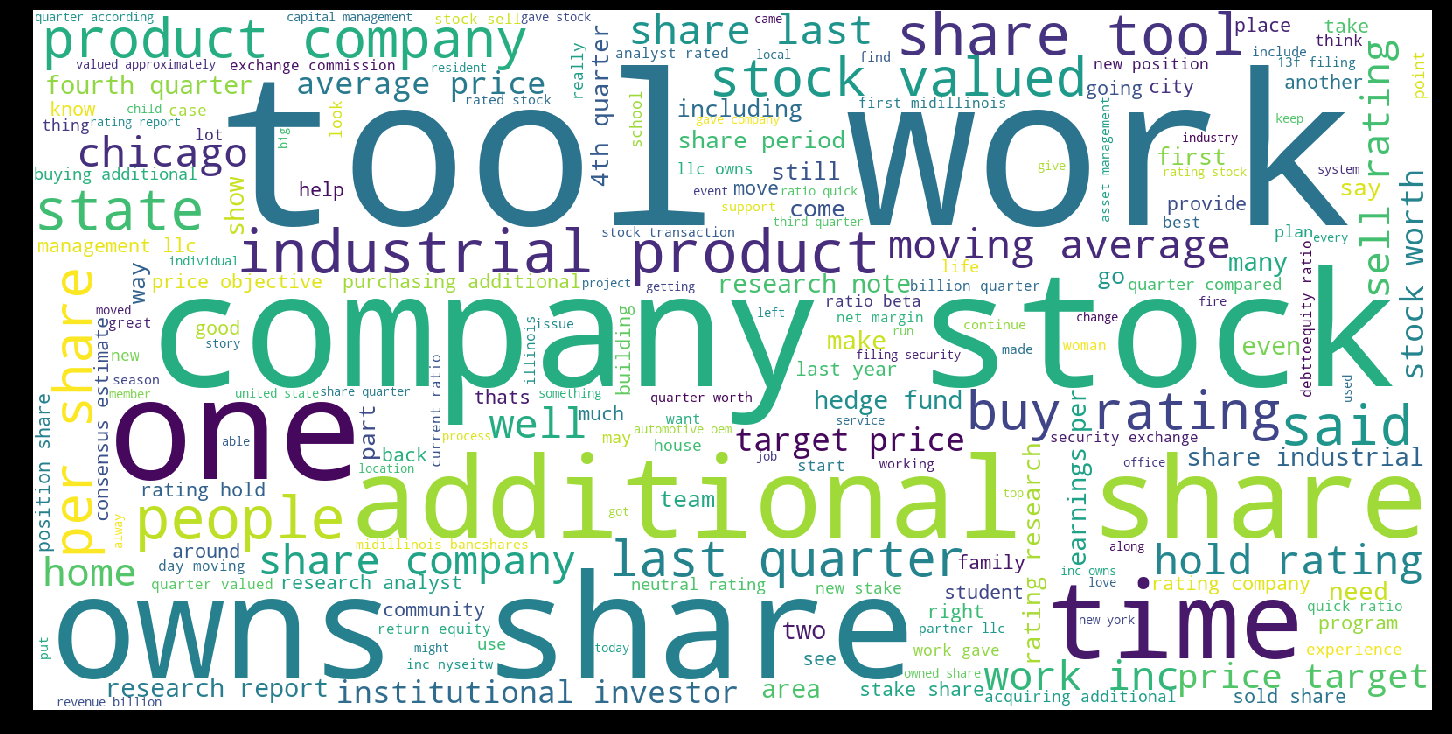

In [332]:
# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

file_content=open ("positive.txt").read()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1600, height=800).generate(file_content)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

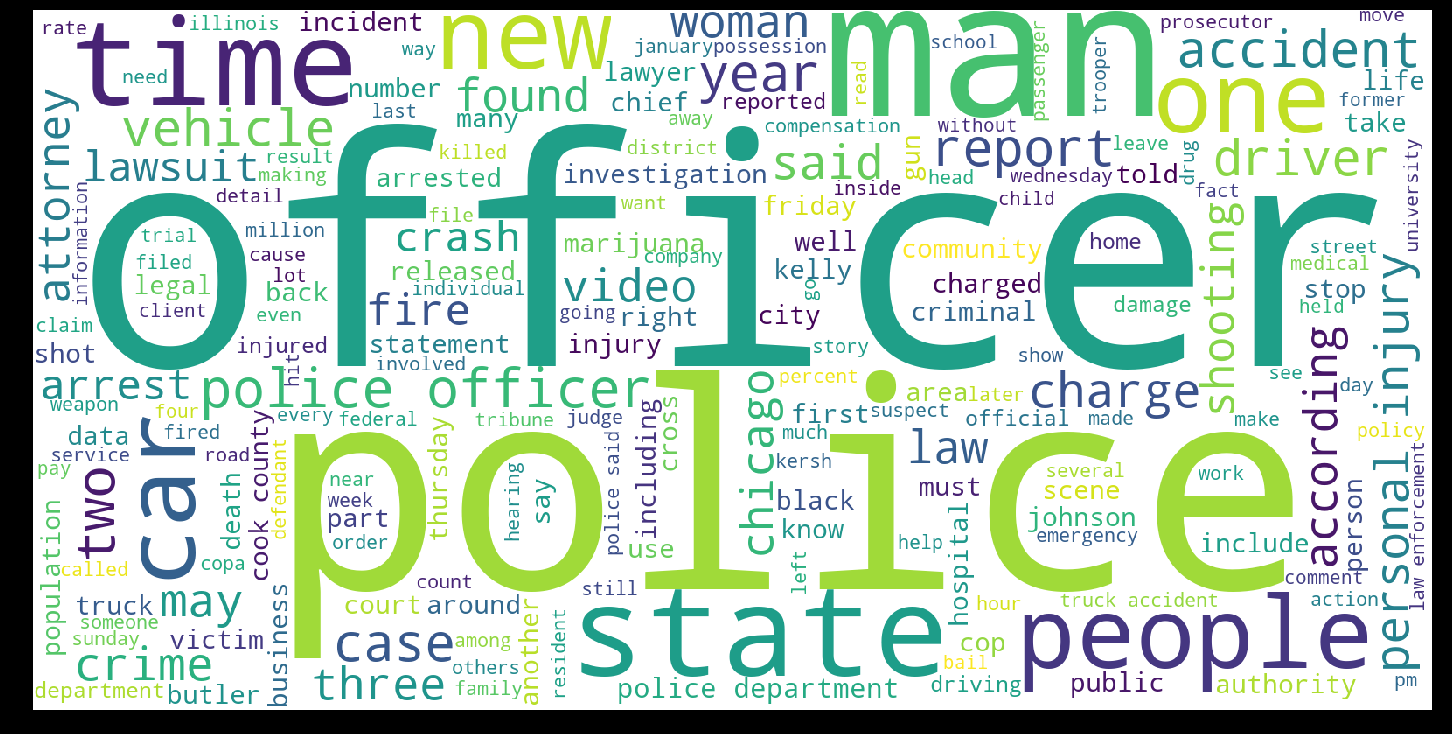

In [333]:
# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

file_content=open ("negative.txt").read()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1600, height=800).generate(file_content)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Name + Entity

In [334]:
text=clean_df['text_clean'].str.cat(sep=', ')

In [335]:
text=str(text)

In [336]:
entities = []
labels = []

for sent in nltk.sent_tokenize(text):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent)), binary = False):
        if hasattr(chunk, 'label'):
            entities.append(' '.join(c[0] for c in chunk)) #Add space as between multi-token entities
            labels.append(chunk.label())

entities_labels = list(set(zip(entities, labels))) #unique entities

In [337]:
entities_df = pd.DataFrame(entities_labels)
entities_df.columns = ["Entities", "Labels"]
entities_df.head(20)

,Entities,Labels
0,u.s.,GPE
1,mr. madox,PERSON
2,u.s.soviet,GPE
3,mr. kelly,PERSON
4,mr. ron,PERSON
5,john j.,PERSON
6,neighborhoods.com,ORGANIZATION
7,south,LOCATION
8,clinton,PERSON
9,trip.com,ORGANIZATION


In [340]:
Person=entities_df[entities_df['Labels']=='PERSON']

In [356]:
#there aren't any people mentioned more than once
Person['Entities'].value_counts().sort_values(ascending=False)

clinton           1
calif.            1
mr. mcgill        1
it.pitt           1
harry             1
                 ..
mr. t.            1
mr. mumbower      1
mr. smollett      1
mr. madox         1
mr. hieronymus    1
Name: Entities, Length: 66, dtype: int64

In [346]:
Org=entities_df[entities_df['Labels']=='ORGANIZATION']

In [347]:
#there aren't any orgs mentioned more than once
Org['Entities'].value_counts().sort_values(ascending=False)

amazon.com             1
u.n.                   1
neighborhoods.com      1
l.a.                   1
n.w.a.                 1
s.a.                   1
u.s.a.                 1
better.com             1
d.c.                   1
mlb.com                1
u.s.                   1
trip.com               1
telegraphherald.com    1
parted.the             1
m.b.a.                 1
u.s                    1
___                    1
Name: Entities, dtype: int64

In [365]:
in_terms = Org['Entities'].tolist()
in_stems=[porter.stem(c) for c in in_terms]
in_index=[]
out_index=[]
for a in range(0, len(clean_df)):
    words=clean_df.iloc[a].text_clean
    stems=[porter.stem(t) for t in words.split()]
    #if any of the keywords are in the title (stems), put those stems in the list
    if any(s in stems for s in in_stems):
        in_index.append(a)
    #if none of the keywords are present insert a Null value
    else:
        out_index.append(a)

### Companies

In [388]:
companies=clean_df.iloc[in_index]
companies.head(20)

,text_clean,contain_stem
7,"jushi announces beginning adultuse cannabis sales illinois dispensary normal, illinois new adultuse customers can only shop online overthephone instore pickup medical patients can shop instore, on...",None
10,"pope francis names father louis tylka archdiocese chicago coadjutor bishop peoria pope francis names father louis tylka archdiocese chicago coadjutor bishop peoria may 11, 2020 washingtonpope fran...",None
28,"how south holland, illinois helping residents protect properties flooding south hollands flood assistance rebate program powerful incentive proactive flooding flood mitigation twenty miles outside...",None
33,"top 10 haunted hot spots illinois ghost stories halloween anymore. nearly every town ghost stories, obscure others however, theres locations well known paranormal encounters hard imagine haunted. ...",None
34,former illinois congressman runs iowa u.s. house seat clinton a former u.s. congressman illinois one five republicans seeking partys nomination iowas 2nd congressional district. i served 112th co...,None
59,"investors give nod worstrated illinois with revenue growing photographer: scott olsongetty images photographer: scott olsongetty images as governor j.b. pritzker nears oneyear anniversary office, ...",None
72,"goodbye, new york, california illinois. hello where 1 4 goodbye, new york, california illinois. hello where bloomberg opinion new york, california illinois hemorrhaging residents. almost 3.2 m...",None
83,"chicago public schools although ex president george bush said popular quote no child left behind , hat happening chicago public schools exactly opposite. even every kid given opportunity go school...",None
85,"fiat chrysler temporarily idle jeep cherokee plant illinois print fca fca invested 350 million belvidere plant, starting 2016, produce cherokee, moved toledo, ohio. belvidere, ill.fiat chrysler au...",None
86,"activist, 23, named vacant chicagoarea state house post illinois news activist, 23, named vacant chicagoarea state house post a 23yearold community activist works u.s. rep. jesus chuy garcia appoi...",None


In [373]:
companies.shape

(2050, 2)

In [392]:
company_sentences=[]
for nn in range(len(companies)):
    c_sentences=nltk.sent_tokenize(companies.iloc[nn].text_clean)
    for mm in c_sentences:
        company_sentences.append(mm)

In [393]:
company_sentences=pd.DataFrame(columns=['Sentence'], data=company_sentences)
company_sentences['Class']=""
company_sentences.shape

(81609, 2)

In [422]:
company_sentences.head()

,Sentence,Class
0,"jushi announces beginning adultuse cannabis sales illinois dispensary normal, illinois new adultuse customers can only shop online overthephone instore pickup medical patients can shop instore, on...",
1,"as previously announced, jushis illinois dispensaries operate companys beyond hello brand.",
2,"on monday, may 11, 2020 9:00 a.m., beyond hello bloomingtonnormal begin serving adultuse customers jushis newly launched online shopping experience www.beyondhello.com overthephone orders instore...",
3,medical patients continue shop instore well place orders online overthephone either curbside instore pickup.,
4,"jim cacioppo, jushis chairman chief executive officer commented, on day two years ago, beyond hello opened first dispensary bristol, pennsylvania.",


### Residents

In [504]:
in_terms = Person['Entities'].tolist()
in_stems=[porter.stem(c) for c in in_terms]
in_index=[]
out_index=[]
for a in range(0, len(clean_df)):
    words=clean_df.iloc[a].text_clean
    stems=[porter.stem(t) for t in words.split()]
    #if any of the keywords are in the title (stems), put those stems in the list
    if any(s in stems for s in in_stems):
        in_index.append(a)
    #if none of the keywords are present insert a Null value
    else:
        out_index.append(a)

In [505]:
residents=clean_df.iloc[in_index]
residents.head(20)

,text_clean,contain_stem
2,families frustrated chicagoarea cemeteries close visitors mothers day dozens chicagoarea families unable pay respects lost loved ones mothers day say cemeteries closed gates visitors without expla...,None
7,"jushi announces beginning adultuse cannabis sales illinois dispensary normal, illinois new adultuse customers can only shop online overthephone instore pickup medical patients can shop instore, on...",None
10,"pope francis names father louis tylka archdiocese chicago coadjutor bishop peoria pope francis names father louis tylka archdiocese chicago coadjutor bishop peoria may 11, 2020 washingtonpope fran...",None
24,"comment chicago fire department history mike mc my dad mentioned driver ss1 article click download this entry posted may 7, 2020, 3:30 pm filed fire department history . you follow responses entry...",None
28,"how south holland, illinois helping residents protect properties flooding south hollands flood assistance rebate program powerful incentive proactive flooding flood mitigation twenty miles outside...",None
33,"top 10 haunted hot spots illinois ghost stories halloween anymore. nearly every town ghost stories, obscure others however, theres locations well known paranormal encounters hard imagine haunted. ...",None
34,former illinois congressman runs iowa u.s. house seat clinton a former u.s. congressman illinois one five republicans seeking partys nomination iowas 2nd congressional district. i served 112th co...,None
59,"investors give nod worstrated illinois with revenue growing photographer: scott olsongetty images photographer: scott olsongetty images as governor j.b. pritzker nears oneyear anniversary office, ...",None
72,"goodbye, new york, california illinois. hello where 1 4 goodbye, new york, california illinois. hello where bloomberg opinion new york, california illinois hemorrhaging residents. almost 3.2 m...",None
83,"chicago public schools although ex president george bush said popular quote no child left behind , hat happening chicago public schools exactly opposite. even every kid given opportunity go school...",None


In [506]:
residents.shape

(2549, 2)

In [508]:
residents_sentences=[]
for nn in range(len(residents)):
    r_sentences=nltk.sent_tokenize(residents.iloc[nn].text_clean)
    for mm in r_sentences:
        residents_sentences.append(mm)

In [509]:
residents_sentences=pd.DataFrame(columns=['Sentence'], data=residents_sentences)
residents_sentences['Class']=""
residents_sentences.shape

(101901, 2)

In [510]:
residents_sentences.head()

,Sentence,Class
0,families frustrated chicagoarea cemeteries close visitors mothers day dozens chicagoarea families unable pay respects lost loved ones mothers day say cemeteries closed gates visitors without expla...,
1,"but number families met locked gates sunday.they might earth, closest get mothers, said gregory harris.for harris, cemetery one place go honor mother dorothy.but dozens cars families stood outside...",
2,"they looking forward seeing moms, harris said.he said small group frustrated people jumped gates leave flowers mothers gravesides.there gentlemen went walls, harris said.",
3,"they want see loved one i understood that.when got there, 20 people so, standing out, wanting get inside.",
4,"they knowledge well, said registered nurse glendra smith.for smith, familys first mothers day without mom, anna pennington, passed away less two months ago.as stood front cedar park, i tears welli...",


# Sentiment Analysis - Company

In [448]:
all_reviews = company_sentences['Sentence']
all_sent_values = []
all_sentiments = []

In [449]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [450]:
for i in range(0,len(all_reviews)):
    all_sent_values.append(sentiment_value(all_reviews[i]))

In [463]:
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0,len(all_reviews)):
    sent = all_sent_values[i]
    if (sent<=1 and sent>0.2):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(2)
    elif (sent<-0.2 and sent>=-1):
        SENTIMENT.append('Negative')
        SENTIMENT_VALUE.append(0)
    else:
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(1)

In [465]:
temp_data = company_sentences['Sentence'].to_frame()

In [466]:
temp_data['SENTIMENT_VALUE'] = SENTIMENT_VALUE
temp_data['SENTIMENT'] = SENTIMENT

In [467]:
temp_data.head()

,Sentence,SENTIMENT_VALUE,SENTIMENT
0,"jushi announces beginning adultuse cannabis sales illinois dispensary normal, illinois new adultuse customers can only shop online overthephone instore pickup medical patients can shop instore, on...",1,Neutral
1,"as previously announced, jushis illinois dispensaries operate companys beyond hello brand.",1,Neutral
2,"on monday, may 11, 2020 9:00 a.m., beyond hello bloomingtonnormal begin serving adultuse customers jushis newly launched online shopping experience www.beyondhello.com overthephone orders instore...",1,Neutral
3,medical patients continue shop instore well place orders online overthephone either curbside instore pickup.,2,Positive
4,"jim cacioppo, jushis chairman chief executive officer commented, on day two years ago, beyond hello opened first dispensary bristol, pennsylvania.",1,Neutral


# Classification - Company

In [468]:
X = temp_data.Sentence
y = temp_data.SENTIMENT_VALUE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 8)

In [469]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(57126,)
(24483,)
(57126,)
(24483,)


In [470]:
y_test.value_counts()

1    11637
2     8460
0     4386
Name: SENTIMENT_VALUE, dtype: int64

In [471]:
#train LR classifier
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])
lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [472]:
%%time

y_pred_lr = lr.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_lr, y_test))

accuracy 0.8206919086713229
Wall time: 387 ms


# Word Cloud - Company

In [474]:
sent_df = X_test.to_frame()
sent_df['prediction']=y_pred_lr.tolist()

In [475]:
#Negative=0, Neutral=1, Positive=2
sent_df['prediction'].value_counts()

1    13929
2     7530
0     3024
Name: prediction, dtype: int64

In [476]:
sent_df.head()

,Sentence,prediction
59288,"merriman shawnee mission, ksarizona state transfer arizona state swims backstroke freestyle events.",1
36004,students may noticed changes food businesses around columbias morningside campus.,1
54078,"wadlow died july 15, 1940 buried coffin measuring 10 feet, 9 inches long, 32 inches wide 30 inches deep.",1
9838,"naturally, someone drunk enough volunteer.",0
40523,"with valets versatile wall bedsmurphy beds, comfort lost.",0


In [480]:
pos_sentences=sent_df[sent_df['prediction']==2]
pos_text=pos_sentences["Sentence"].tolist()
pos_text[0:2]

['but trade deals created equal, people benefit readily them.',
 'restaurants facing higher costs food labor, increasing competition limits ability raise prices.']

In [481]:
neg_sentences=sent_df[sent_df['prediction']==0]
neg_text=neg_sentences["Sentence"].tolist()
neg_text[0:2]

['naturally, someone drunk enough volunteer.',
 'with valets versatile wall bedsmurphy beds, comfort lost.']

In [482]:
pos_sentences.to_pickle('pos_sentences.pickle')
neg_sentences.to_pickle('neg_sentences.pickle')

In [485]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [486]:
pos_clean = [clean(doc).split() for doc in pos_text]

In [487]:
neg_clean = [clean(doc).split() for doc in neg_text]

In [488]:
pos_words=[]
for u in range(len(pos_clean)):
    words=pos_clean[u]
    for v in words:
        pos_words.append(v)
        
pos_string=" ".join(pos_words)

In [489]:
neg_words=[]
for w in range(len(neg_clean)):
    words=neg_clean[w]
    for x in words:
        neg_words.append(x)
        
neg_string=" ".join(neg_words)

In [490]:
pos_text_file = open("positive_company.txt", "w")
pos_text_file.write(pos_string)
pos_text_file.close()
with open('negative_company.txt', 'w', encoding='utf-8') as neg_text_file:
    neg_text_file.write(neg_string)

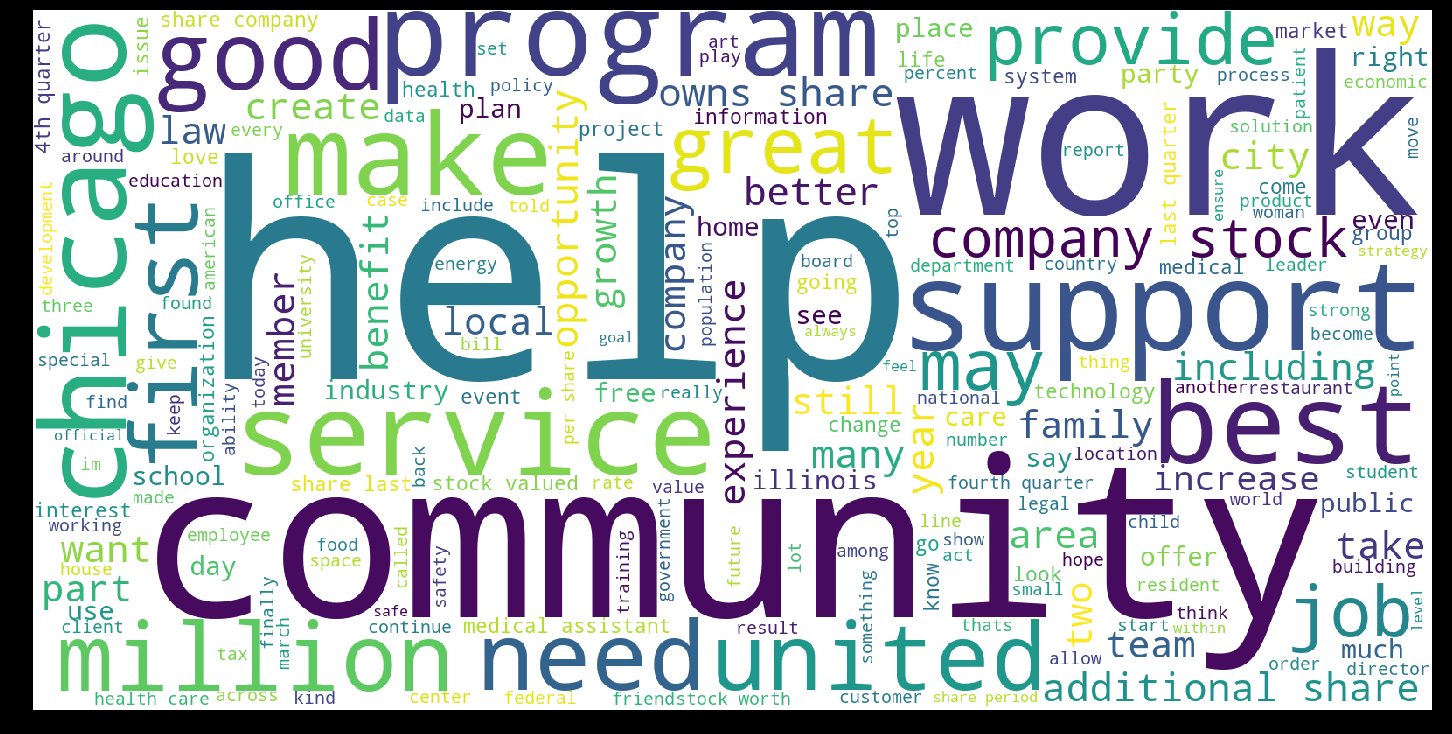

In [498]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["state", "new", "one",'well','time','said','people','business'])

file_content=open ("positive_company.txt").read()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1600, height=800).generate(file_content)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

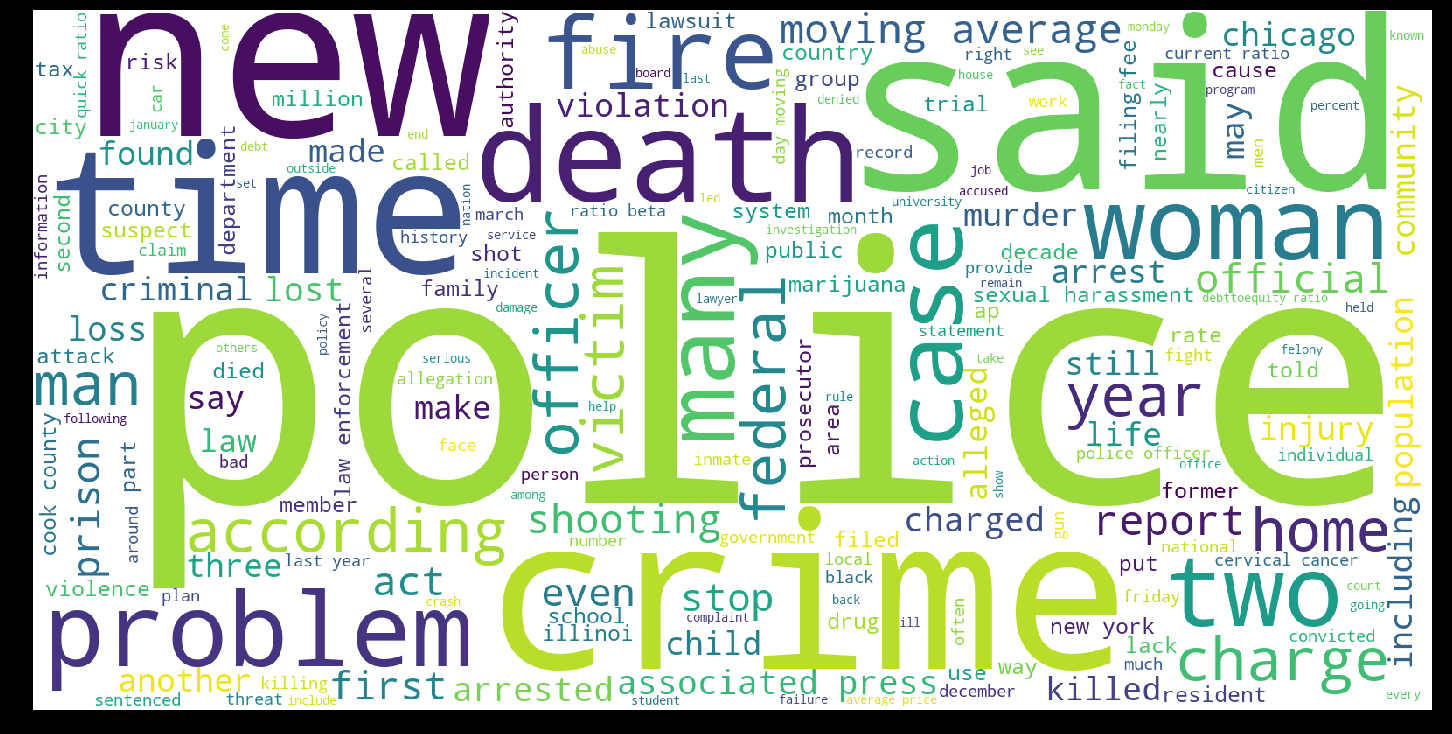

In [499]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["state",'people','one'])

file_content=open ("negative_company.txt").read()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1600, height=800).generate(file_content)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Sentiment Analysis - Resident

In [511]:
all_reviews = residents_sentences['Sentence']
all_sent_values = []
all_sentiments = []

In [512]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [513]:
for i in range(0,len(all_reviews)):
    all_sent_values.append(sentiment_value(all_reviews[i]))

In [514]:
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0,len(all_reviews)):
    sent = all_sent_values[i]
    if (sent<=1 and sent>0.2):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(2)
    elif (sent<-0.2 and sent>=-1):
        SENTIMENT.append('Negative')
        SENTIMENT_VALUE.append(0)
    else:
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(1)

In [519]:
temp_data = residents_sentences['Sentence'].to_frame()

In [520]:
temp_data['SENTIMENT_VALUE'] = SENTIMENT_VALUE
temp_data['SENTIMENT'] = SENTIMENT

In [521]:
temp_data.head()

,Sentence,SENTIMENT_VALUE,SENTIMENT
0,families frustrated chicagoarea cemeteries close visitors mothers day dozens chicagoarea families unable pay respects lost loved ones mothers day say cemeteries closed gates visitors without expla...,0,Negative
1,"but number families met locked gates sunday.they might earth, closest get mothers, said gregory harris.for harris, cemetery one place go honor mother dorothy.but dozens cars families stood outside...",2,Positive
2,"they looking forward seeing moms, harris said.he said small group frustrated people jumped gates leave flowers mothers gravesides.there gentlemen went walls, harris said.",0,Negative
3,"they want see loved one i understood that.when got there, 20 people so, standing out, wanting get inside.",2,Positive
4,"they knowledge well, said registered nurse glendra smith.for smith, familys first mothers day without mom, anna pennington, passed away less two months ago.as stood front cedar park, i tears welli...",1,Neutral


# Classification - Resident

In [522]:
X = temp_data.Sentence
y = temp_data.SENTIMENT_VALUE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 8)

In [523]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(71330,)
(30571,)
(71330,)
(30571,)


In [524]:
y_test.value_counts()

1    14658
2    10339
0     5574
Name: SENTIMENT_VALUE, dtype: int64

In [525]:
#train LR classifier
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])
lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
  

In [526]:
%%time

y_pred_lr = lr.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred_lr, y_test))

accuracy 0.8265676621634883
Wall time: 518 ms


# Word Cloud - Resident

In [527]:
sent_df = X_test.to_frame()
sent_df['prediction']=y_pred_lr.tolist()

In [528]:
#Negative=0, Neutral=1, Positive=2
sent_df['prediction'].value_counts()

1    17208
2     9472
0     3891
Name: prediction, dtype: int64

In [529]:
sent_df.head()

,Sentence,prediction
87432,"people ineligible commission include: lobbyists persons appointed, running elected position state, federal, local government paid consultant campaign representative political candidate political a...",2
70774,"casey leins may 14, 2019 these places best america educating students levels.",2
30872,"i get really upset people object pipelines oil still transported rail, aziz said.",0
85930,"ethics reform the republicans best hope minimize losses, jackson said.",2
80641,"as aide schmitz, goncher served liaison constituents state agencies.",1


In [530]:
pos_sentences=sent_df[sent_df['prediction']==2]
pos_text=pos_sentences["Sentence"].tolist()
pos_text[0:2]

['people ineligible commission include: lobbyists persons appointed, running elected position state, federal, local government paid consultant campaign representative political candidate political action committee individual ownership interest entity state, local federal contract appointed elected officials political party.',
 'casey leins may 14, 2019 these places best america educating students levels.']

In [531]:
neg_sentences=sent_df[sent_df['prediction']==0]
neg_text=neg_sentences["Sentence"].tolist()
neg_text[0:2]

['i get really upset people object pipelines oil still transported rail, aziz said.',
 'johnson, married, initially blamed failure take blood pressure medication said drinks dinner earlier evening.']

In [532]:
pos_sentences.to_pickle('pos_sentences.pickle')
neg_sentences.to_pickle('neg_sentences.pickle')

In [533]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [534]:
pos_clean = [clean(doc).split() for doc in pos_text]

In [535]:
neg_clean = [clean(doc).split() for doc in neg_text]

In [536]:
pos_words=[]
for u in range(len(pos_clean)):
    words=pos_clean[u]
    for v in words:
        pos_words.append(v)
        
pos_string=" ".join(pos_words)

In [537]:
neg_words=[]
for w in range(len(neg_clean)):
    words=neg_clean[w]
    for x in words:
        neg_words.append(x)
        
neg_string=" ".join(neg_words)

In [538]:
pos_text_file = open("positive_resident.txt", "w")
pos_text_file.write(pos_string)
pos_text_file.close()
with open('negative_resident.txt', 'w', encoding='utf-8') as neg_text_file:
    neg_text_file.write(neg_string)

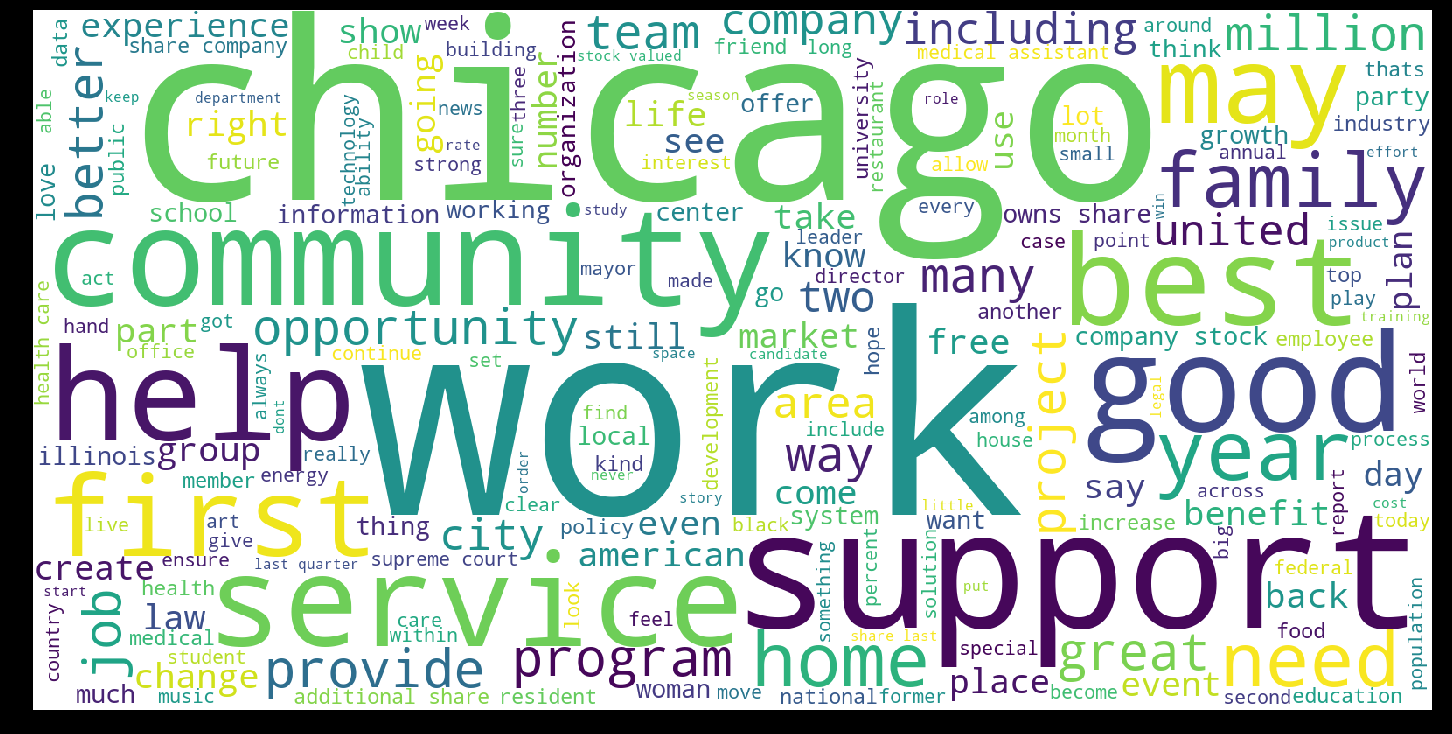

In [545]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['people','new','one','state','well','said','time','business','make'])

file_content=open ("positive_resident.txt").read()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1600, height=800).generate(file_content)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

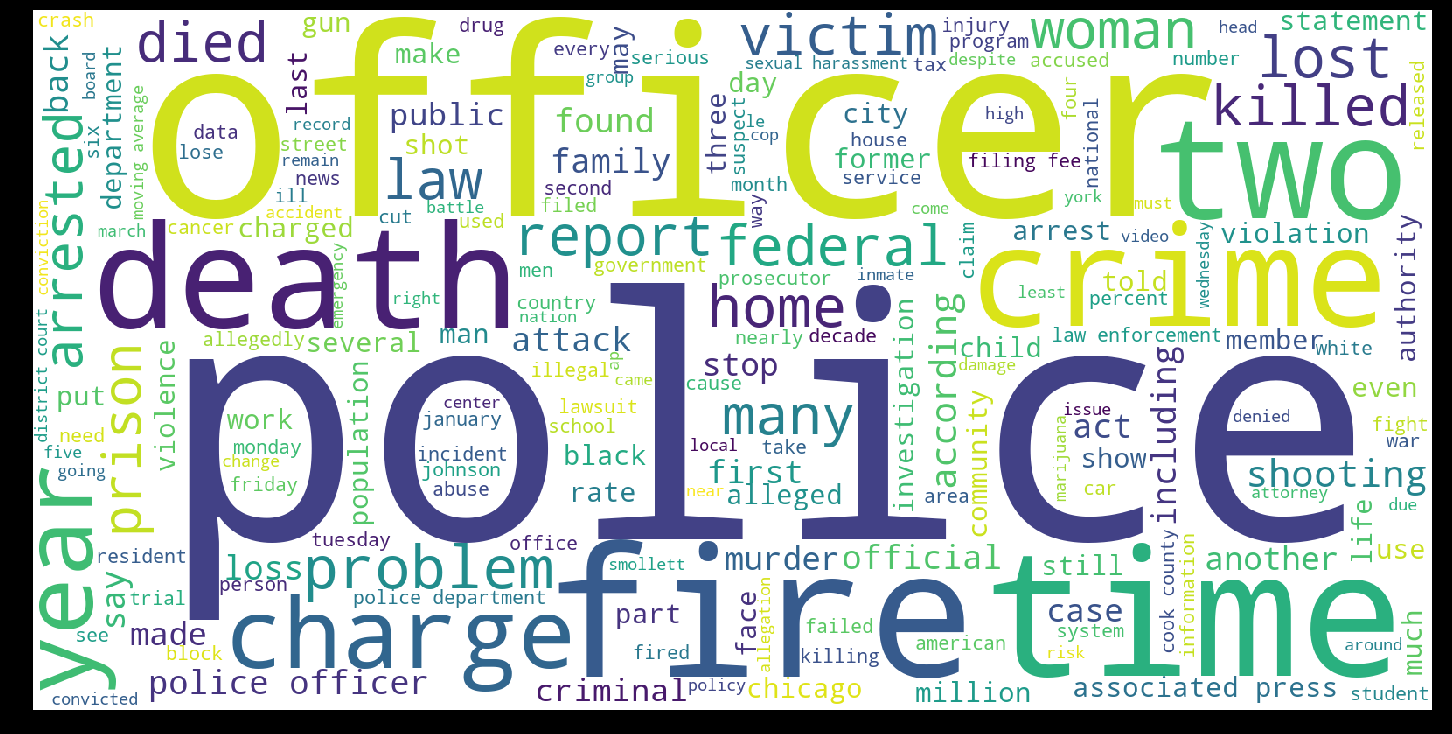

In [548]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["state",'people','one','said','new'])

file_content=open ("negative_resident.txt").read()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=1600, height=800).generate(file_content)

# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()